In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

pd.set_option('max_columns', 50)

# Stationarity

In [2]:
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
sales=pd.read_csv("data/sales_train.csv")
item_cat=pd.read_csv("data/item_categories.csv")
item=pd.read_csv("data/items.csv")
shops=pd.read_csv("data/shops.csv")

In [4]:
sales['date'] = pd.to_datetime(sales['date'])
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [5]:
monthly_sales=sales.groupby(["date_block_num",
                             "shop_id",
                             "item_id"])[["date",
                                         "item_price",
                                         "item_cnt_day"]].agg({"date":["min",'max'],
                                                              "item_price":"mean",
                                                              "item_cnt_day":"sum"})

monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-21 2013-03-01      221.0          6.0
                       33      2013-01-17 2013-03-01      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

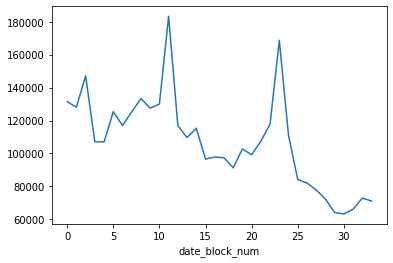

In [6]:
sales.groupby(["date_block_num"])["item_cnt_day"].sum().plot()

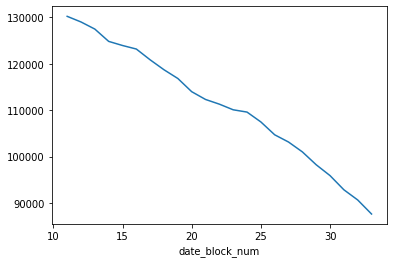

In [7]:
sales.groupby(["date_block_num"])["item_cnt_day"].sum().rolling(window=12,center=False).mean().plot()

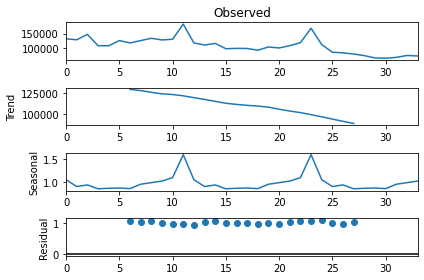

In [8]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()

# multiplicative
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="multiplicative")
res.plot()
plt.show()

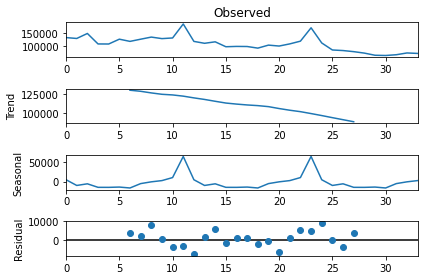

In [9]:
# additive
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="additive")
res.plot()
plt.show()

In [10]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


The value is above all the critical values, it is not a stationary series

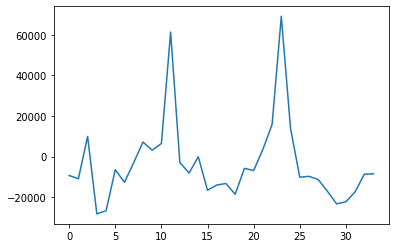

In [11]:
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="additive", extrapolate_trend='freq')
detrended = ts.values - res.trend

plt.plot(detrended)

In [12]:
test_stationarity(detrended)

Results of Dickey-Fuller Test:
Test Statistic                -9.632274e+00
p-value                        1.600420e-16
#Lags Used                     1.000000e+01
Number of Observations Used    2.300000e+01
Critical Value (1%)           -3.752928e+00
Critical Value (5%)           -2.998500e+00
Critical Value (10%)          -2.638967e+00
dtype: float64


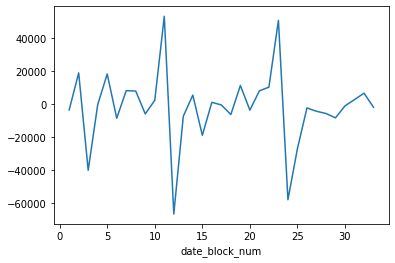

In [13]:
detrended = ts.diff()
detrended.plot()

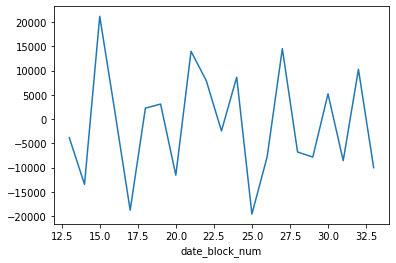

In [14]:
deseasonalized = detrended.diff(12)

deseasonalized.plot()

In [15]:
test_stationarity(detrended.dropna())
test_stationarity(deseasonalized.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.363622e+01
p-value                        1.686395e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.002134e+00
p-value                        1.647765e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.000000e+01
Critical Value (1%)           -3.809209e+00
Critical Value (5%)           -3.021645e+00
Critical Value (10%)          -2.650713e+00
dtype: float64


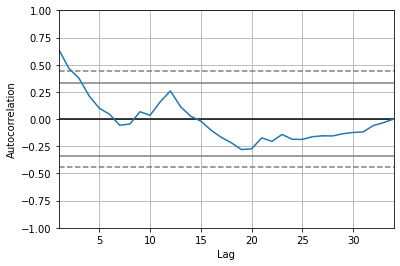

In [16]:
autocorrelation_plot(ts.values)

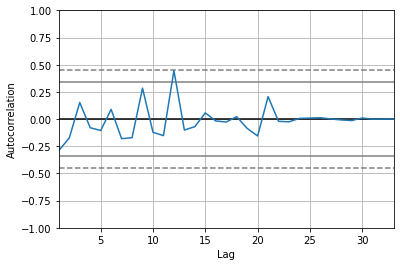

In [17]:
autocorrelation_plot(detrended.dropna())

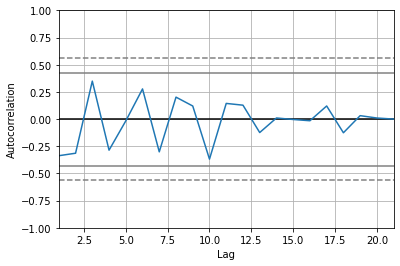

In [18]:
autocorrelation_plot(deseasonalized.dropna())

/home/lucabasa/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


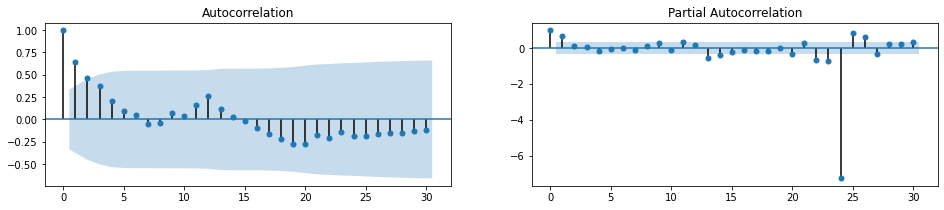

In [19]:
fig, axes = plt.subplots(1,2,figsize=(16,3))
plot_acf(ts.values, lags=30, ax=axes[0])
plot_pacf(ts.values, lags=30, ax=axes[1])
plt.show()

/home/lucabasa/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


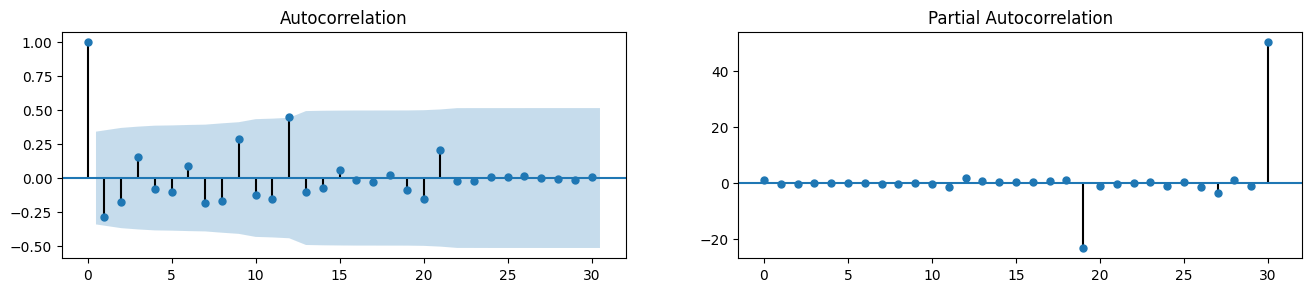

In [20]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(detrended.dropna(), lags=30, ax=axes[0])
plot_pacf(detrended.dropna(), lags=30, ax=axes[1])
plt.show()

/home/lucabasa/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


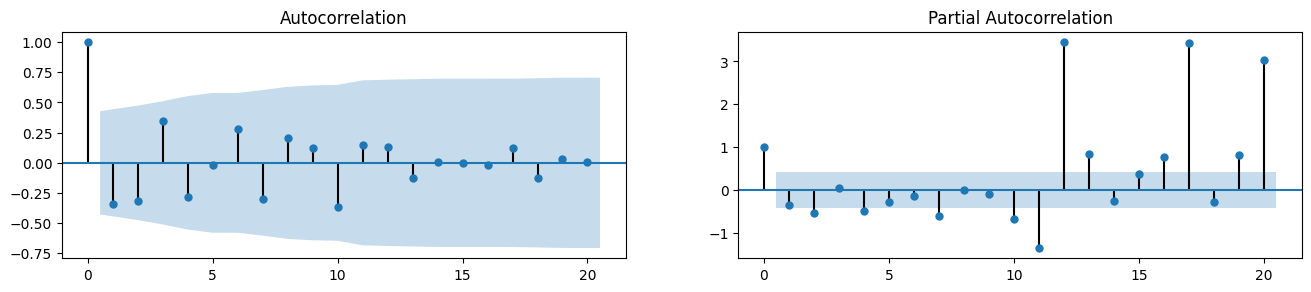

In [21]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(deseasonalized.dropna(), lags=20, ax=axes[0])
plot_pacf(deseasonalized.dropna(), lags=20, ax=axes[1])
plt.show()

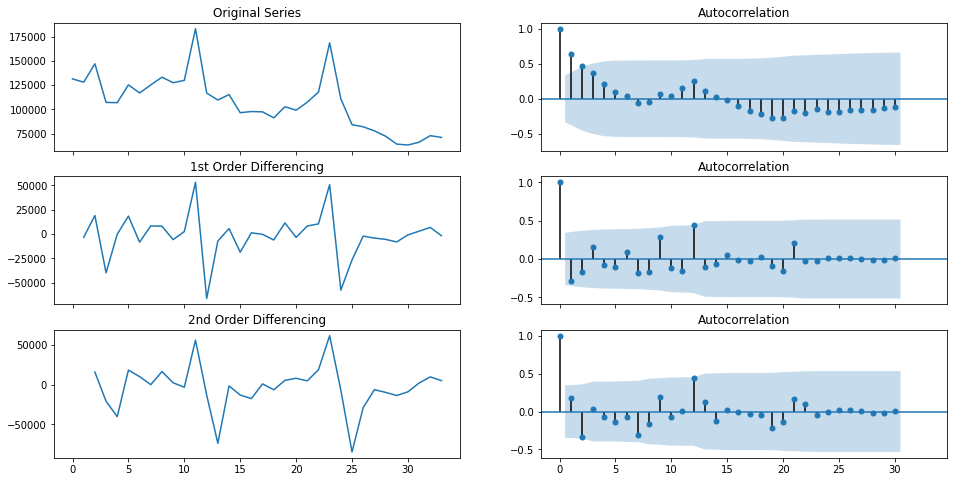

In [22]:
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(16,8))

axes[0, 0].plot(ts.values)
axes[0, 0].set_title('Original Series')
plot_acf(ts, ax=axes[0, 1], lags=30)

# 1st Differencing
axes[1, 0].plot(ts.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(ts.diff().dropna(), ax=axes[1, 1], lags=30)

# 2nd Differencing
axes[2, 0].plot(ts.diff(2))
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(ts.diff(2).dropna(), ax=axes[2, 1], lags=30)

plt.show()

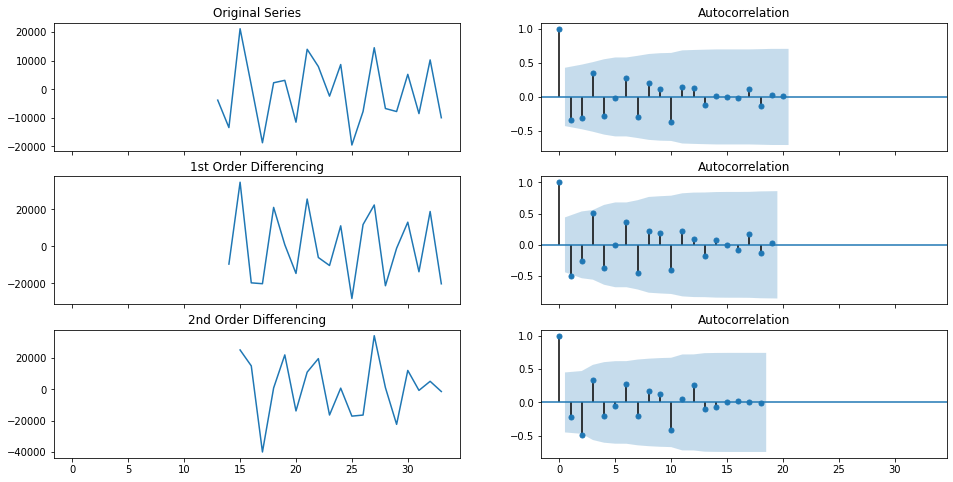

In [23]:
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(16,8))

axes[0, 0].plot(deseasonalized.dropna())
axes[0, 0].set_title('Original Series')
plot_acf(deseasonalized.dropna(), ax=axes[0, 1], lags=20)

# 1st Differencing
axes[1, 0].plot(deseasonalized.diff().dropna())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(deseasonalized.diff().dropna(), ax=axes[1, 1], lags=19)

# 2nd Differencing
axes[2, 0].plot(deseasonalized.diff(2).dropna())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(deseasonalized.diff(2).dropna(), ax=axes[2, 1], lags=18)

plt.show()

# ARIMA

In [24]:
# 1,1,1 ARIMA Model
model = ARIMA(ts, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.item_cnt_day   No. Observations:                   33
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -373.574
Method:                       css-mle   S.D. of innovations          19171.399
Date:                Mon, 04 May 2020   AIC                            755.147
Time:                        16:30:43   BIC                            761.133
Sample:                             1   HQIC                           757.161
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1929.8794    547.474     -3.525      0.000   -3002.908    -856.851
ar.L1.D.item_cnt_day     0.4257      0.163      2.616      0.009       0.107       0.745
ma.L1.D.item

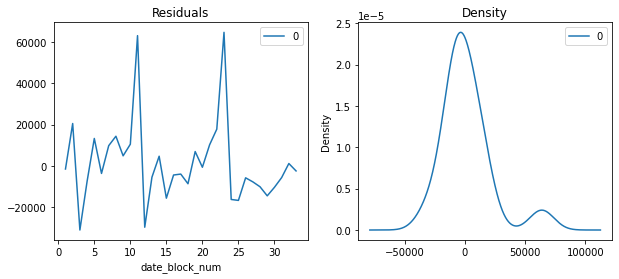

In [25]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(10,4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

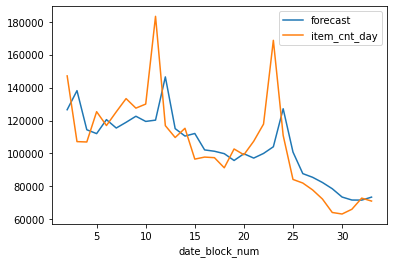

In [26]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [27]:
# Create Training and Test
train = ts.iloc[:27]
test = ts.iloc[27:]

                             ARIMA Model Results                              
Dep. Variable:         D.item_cnt_day   No. Observations:                   26
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -296.559
Method:                       css-mle   S.D. of innovations          20651.882
Date:                Mon, 04 May 2020   AIC                            601.118
Time:                        16:30:44   BIC                            606.150
Sample:                             1   HQIC                           602.567
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1210.4545    708.528     -1.708      0.088   -2599.145     178.235
ar.L1.D.item_cnt_day     0.3119      0.195      1.597      0.110      -0.071       0.695
ma.L1.D.item

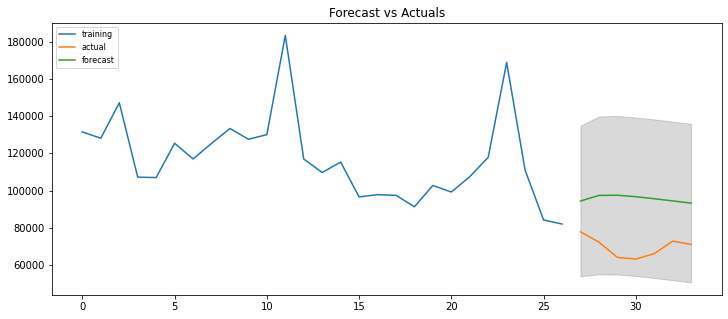

In [28]:
# Build Model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=0, maxiter=5000)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:        D2.item_cnt_day   No. Observations:                   25
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -290.498
Method:                       css-mle   S.D. of innovations          24968.525
Date:                Mon, 04 May 2020   AIC                            588.996
Time:                        16:30:44   BIC                            593.872
Sample:                             2   HQIC                           590.348
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -202.1057    529.672     -0.382      0.703   -1240.244     836.032
ar.L1.D2.item_cnt_day    -0.2630      0.189     -1.391      0.164      -0.634       0.108
ma.L1.D2

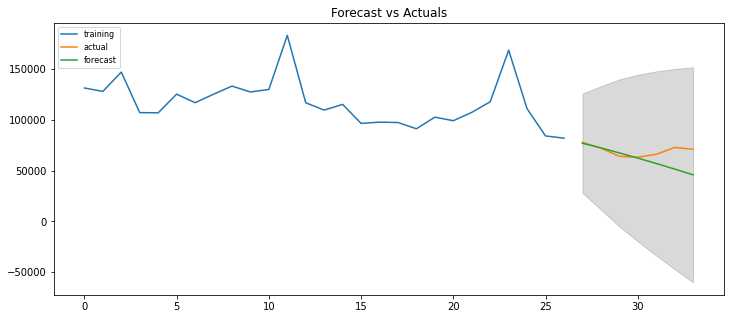

In [29]:
# Build Model
model = ARIMA(train, order=(1, 2, 1))  
fitted = model.fit(disp=0, maxiter=5000)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.12302578080719336,
 'me': -7673.356246591266,
 'mae': 8664.036661952958,
 'mpe': -0.10763097596711027,
 'rmse': 12996.038822560928,
 'acf1': 0.6001854065153701,
 'corr': 0.21881554978182396,
 'minmax': 0.12265386264144229}

In [35]:
model = pm.auto_arima(ts, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=768.629, BIC=771.561, Time=0.007 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=760.678, BIC=765.075, Time=0.017 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=749.331, BIC=753.728, Time=0.059 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=766.689, BIC=768.155, Time=0.003 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=756.635, BIC=762.498, Time=0.018 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=751.286, BIC=757.149, Time=0.057 seconds
Near non-invertible roots for order (0, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=752.850, BIC=760.179, Time=0.103 seconds
Total fit time: 0.271 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:  

In [48]:
model = pm.auto_arima(ts.values, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,1,1,12) [intercept=True]; AIC=450.821, BIC=453.808, Time=0.050 seconds
Fit ARIMA(0,2,0)x(0,1,0,12) [intercept=True]; AIC=453.306, BIC=455.297, Time=0.006 seconds
Fit ARIMA(1,2,0)x(1,1,0,12) [intercept=True]; AIC=451.404, BIC=455.387, Time=0.056 seconds
Fit ARIMA(0,2,1)x(0,1,1,12) [intercept=True]; AIC=438.240, BIC=442.223, Time=0.270 seconds
Fit ARIMA(0,2,0)x(0,1,0,12) [intercept=False]; AIC=451.736, BIC=452.732, Time=0.008 seconds
Fit ARIMA(0,2,1)x(0,1,0,12) [intercept=True]; AIC=437.635, BIC=440.622, Time=0.067 seconds
Near non-invertible roots for order (0, 2, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(0,2,1)x(1,1,1,12) [intercept=True]; AIC=442.836, BIC=447.814, Time=0.284 seconds
Near non-invertible roots for order (0, 2, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
F

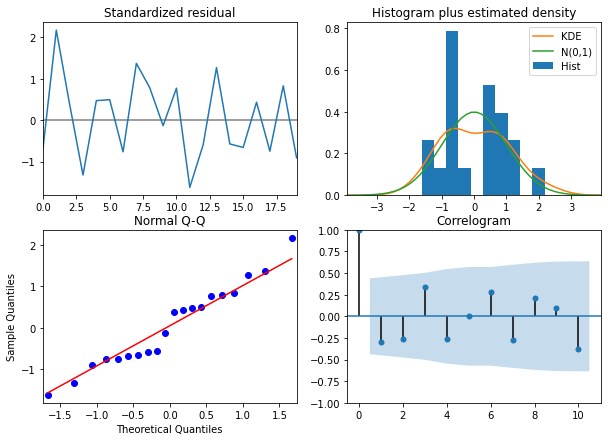

In [49]:
model.plot_diagnostics(figsize=(10,7))
plt.show()

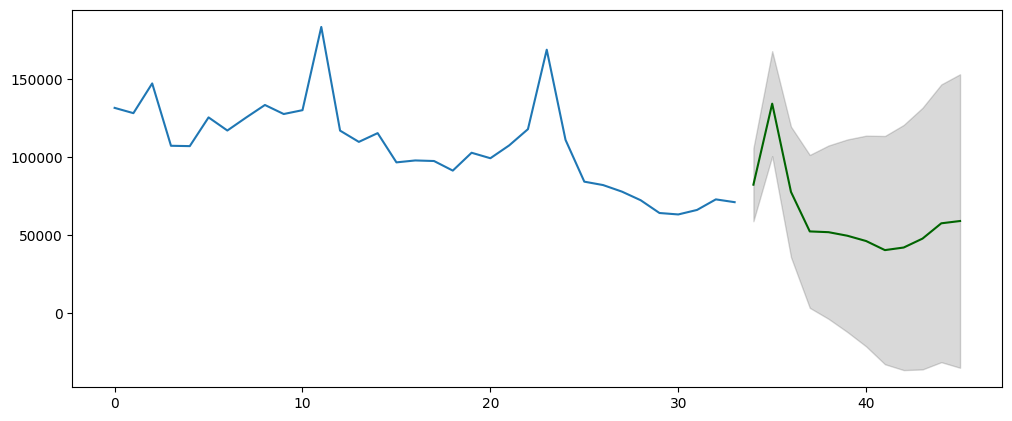

In [50]:
# Forecast
n_periods = 12
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(ts), len(ts)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(ts)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.show()